<a href="https://colab.research.google.com/github/NinelK/SA_DS_tutorial/blob/angles/DS_Tutorial_Part_3_SOLUTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setups

In [1]:
import datetime
import h5py
import jax.numpy as jnp
from jax.scipy.linalg import inv
from jax import random
from jax.experimental import optimizers
from jax.config import config
from jax.nn import relu
from jax.random import poisson as jpoisson
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as np  # original CPU-backed NumPy
import os
import sys
from importlib import reload
from tqdm import tqdm
import time

from sklearn.decomposition import PCA
start = time.time()

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [2]:
%%capture
! git clone -b SA_tutorial https://github.com/NinelK/jax-lfads.git
# ! rm -r /content/jax-lfads/

In [3]:
# You must change this to the location of the computation-thru-dynamics directory.
HOME_DIR = '/content' 

sys.path.append(os.path.join(HOME_DIR,'jax-lfads'))
import lfads_tutorial.lfads as lfads
import lfads_tutorial.utils as utils
from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun

In [4]:
# Make directories
lfads_dir = '/content/lfads/'       # where to save lfads data and parameters to
output_dir = os.path.join(lfads_dir, 'output/')
figure_dir = os.path.join(lfads_dir, os.path.join(output_dir, 'figures/'))
if not os.path.exists(lfads_dir):
    os.makedirs(output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

# Part 3: Recurrent neural networks (RNNs) as dynamical systems

### Vanilla RNN


Let us first consider the simplest, yet most important example of a non-linear discrete-time latent dynamical system: a **recurrent neural network**. It is a go-to tool for modelling sequences in deep learning.

Latent dynamics: $$h_{t} = \sigma (V h_{t-1} + U x_t + b_h)$$
Emission model: $$o_t = W h_t + b_o $$


![RNN scheme (Wiki)](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/2560px-Recurrent_neural_network_unfold.svg.png)


Similarly to the multi-layer networks that you have seen in a previous tutorial, RNNs can be trained through a backpropagation. Although, instead of propagating gradients through layers, here we would propagate gradients throught **time**. To see how this can be done, we need to unfold timesteps into a sequence (right plot above). In these unfolded scheme, each column is a 2-layer perceptron. The new thing is a transition from the previous time step to the next. This is called backpropagation through time (BPTT).

#### Exercise 1: Implement a Vanilla RNN

In [5]:
def vanilla_rnn_params(key, n, u, ifactor=1.0, hfactor=1., hscale=0.0):
  """Initialize Vanilla RNN parameters for LFADS

  Arguments:
    key: random.PRNGKey for random bits
    n: hidden state size
    u: input size
    ifactor: scaling factor for input weights
    hfactor: scaling factor for hidden -> hidden weights
    hscale: scale on h0 initial condition

  Returns:
    a dictionary of parameters
  """
  key, skeys = utils.keygen(key, 3)
  ifactor = ifactor / jnp.sqrt(u)
  hfactor = hfactor / jnp.sqrt(n)

  h0 = random.normal(next(skeys), (n,)) * hscale
  wA = random.normal(next(skeys), (n,n)) * hfactor
  wB = random.normal(next(skeys), (n,u)) * ifactor
  wb = jnp.zeros((n,))

  return {'h0' : h0,
          'wA' : wA,
          'wB' : wB,
          'wb' : wb}


def vanilla_rnn(params, h, x, nonlin=jnp.tanh):
  """Implement the Vanilla RNN equations.

  Arguments:
    params: dictionary of RNN parameters
    h: np array of hidden state
    x: np array of input

  Returns:
    np array of hidden state after RNN update"""
  h_new = nonlin(jnp.dot(params['wA'], h) + jnp.dot(params['wB'], x) + params['wb']) #2remove
  return h_new


## RNN-based generative models of neuronal population dynamics

RNNs are used in neuroscience for modelling populations of neurons. In general, fitting an RNN to data allows one to speculate about the *computation* that the neural population is performing.
However, there are multiple options for describing neuronal populations with RNNs, which can be divided into 2 large groups [3]: 
1. **Fully-observed models:** In these models, RNN units (components of vactor $\mathbf{h}$) would have 1-to-1 correspondence to single neural firing rates, while outputs $\mathbf{o}$ can correspond to some behavioral outputs (e.g. hand position in space).
2. **Latent dynamics models:** in these models neural firing rates would correspond to the outputs $\mathbf{o}$, while $\mathbf{h}$ (latent state) would summarize what a neuronal population as a whole is doing.

![two model types](https://drive.google.com/uc?export=view&id=16G4HWvarW8rtNlBSlnCvCIcJq78Pr7Lu)

In this tutorial, we will focus on the second class of models: the models of latent dynamics.

## Forward problem: generating data from a latent dynamics model

#### Exercise 2: Generate some spike data from a VRNN

Suppose a neural population with $N$ neurons follows a simple dynamics. Let's imagine that it oscillates. We can describe this dynamics with 2 latent factors, similarly to a pendulum in Tutorial Part 1.

$${\begin{bmatrix}
    \dot h_1 \\
    \dot h_2
\end{bmatrix}} = \begin{bmatrix}
    0 & 1 \\
    -1 & 0
\end{bmatrix} \begin{bmatrix}
    h_1 \\
    h_2
\end{bmatrix} $$

Now, suppose log-firing rate of each neuron in a population is a sum of these two factors with some arbitrarily chosen coefficients:

$${\begin{bmatrix}
    \log r_1 \\
    \log r_2 \\
    \ldots \\
    \log r_N
\end{bmatrix}} = {\begin{bmatrix}
    o_1 \\
    o_2 \\
    \ldots \\
    o_N
\end{bmatrix}} = \underbrace{B}_{N \times 2} \begin{bmatrix}
    h_1 \\
    h_2
\end{bmatrix} + {\begin{bmatrix}
    b_1 \\
    b_2 \\
    \ldots \\
    b_N
\end{bmatrix}}$$

$$\mathrm{spikes}_i \sim \mathrm{Poisson}(r_i)$$

TODO: introduce a term "generative model"

Let us implement this model and generate some spikes:

In [6]:
def emission_model(params, h, key):
  key, skeys = utils.keygen(key, 1)
  o = jnp.dot(params['wW'],h) + params['wbo']
  s = jpoisson(next(skeys), jnp.exp(o))
  return s

def generative_model(params, h, x, skeys):
  h = vanilla_rnn(params, h, x, nonlin=lambda x: x)
  s = emission_model(params, h, skeys)
  return h, s

n,N = 2, 100
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
w = .2
params = {'wA' : jnp.array([[np.sqrt(1.-w**2),w],[-w,np.sqrt(1.-w**2)]]),
          'wB' : jnp.zeros((2,2)),
          'wb' : jnp.zeros((n,)),
          'wW' : random.normal(key, (N,n)),
          'wbo': jnp.zeros((N,))}
T = 50
num_trials = 200
synth_spikes = []
reach_angle = []
for _ in tqdm(range(num_trials)):
  a = np.random.uniform() *2 * jnp.pi - jnp.pi
  h = jnp.array([np.sin(a),np.cos(a)]).flatten()
  spikes_this_trial = []
  for t in range(T):
    key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
    h, s = generative_model(params, h, jnp.zeros((n,)), key)
    spikes_this_trial.append(s)
  synth_spikes.append(spikes_this_trial)
  reach_angle.append(a)

100%|██████████| 200/200 [01:25<00:00,  2.33it/s]


## Backward problem: inferring dynamics & initial conditions using LFADS

Auto-encoding sequential neural data with RNN-based LFADS model 

TODO: Add LFADS intro

In [7]:
data_bxtxn = np.array(synth_spikes)
reach_angle = np.array(reach_angle).flatten()
print(data_bxtxn.shape)

data_dt = 10.0        # define our dt in a physiological range [ms]

train_fraction = 0.9      # Train with 90% of the synthetic data

nexamples, ntimesteps, data_dim = data_bxtxn.shape

train_data, eval_data = utils.split_data(data_bxtxn,
                                         train_fraction=train_fraction)
eval_data_offset = int(train_fraction * data_bxtxn.shape[0])


(200, 50, 100)


### Set LFADS Parameters

In [8]:
# LFADS Hyper parameters
data_dim = train_data.shape[2]  # input to lfads should have dimensions:
ntimesteps = train_data.shape[1] #   (batch_size x ntimesteps x data_dim)
batch_size = 200      # batch size during optimization

# LFADS architecture - The size of the numbers is rather arbitrary, 
# but relatively small because we know the integrator RNN isn't too high 
# dimensional in its activity.
enc_dim = 2         # encoder dim
con_dim = 0          # controller dim
ii_dim = 0           # inferred input dim
gen_dim = 2         # generator dim, should be large enough
factors_dim = gen_dim      # factors dim, should be large enough to capture most variance of dynamics

# Numerical stability
var_min = 0.001 # Minimal variance any gaussian can become.

# Optimization HPs that percolates into model
l2reg = 0.00002

# Initial state prior parameters
# the mean is set to zero in the code
ic_prior_var = 0.1 # this is $\sigma^2_p$ in above paragraph

# Inferred input autoregressive prior parameters
ar_mean = 0.0                 # process mean
ar_autocorrelation_tau = 1.0  # seconds, how correlated each time point is, related to $\phi$ above.
ar_noise_variance = 0.1       # noise variance

lfads_hps = {'data_dim' : data_dim, 'ntimesteps' : ntimesteps,
             'enc_dim' : enc_dim, 'con_dim' : con_dim, 'var_min' : var_min,
             'ic_prior_var' : ic_prior_var, 'ar_mean' : ar_mean,
             'ar_autocorrelation_tau' : ar_autocorrelation_tau,
             'ar_noise_variance' : ar_noise_variance,
             'ii_dim' : ii_dim, 'gen_dim' : gen_dim,
             'factors_dim' : factors_dim,
             'l2reg' : l2reg,
             'batch_size' : batch_size}

num_batches = 3000         # how many batches do we train
print_every = 100            # give information every so often

# Learning rate HPs
step_size = 0.01            # initial learning rate
decay_factor = 0.9998       # learning rate decay param
decay_steps = 1             # learning rate decay param

# Regularization HPs
keep_rate = 0.95             # dropout keep rate during training

# Numerical stability HPs
max_grad_norm = 10.0        # gradient clipping above this value

# The fact that the start and end values are required to be floats is something I need to fix.
kl_warmup_start = 0.0 # batch number to start KL warm-up, explicitly float
kl_warmup_end = 1000.0  # batch number to be finished with KL warm-up, explicitly float
kl_min = .001 # The minimum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.
kl_max = 1.

lfads_opt_hps = {'num_batches' : num_batches, 'step_size' : step_size,
                 'decay_steps' : decay_steps, 'decay_factor' : decay_factor,
                 'kl_min' : kl_min, 'kl_max' : kl_max, 'kl_warmup_start' : kl_warmup_start,
                 'kl_warmup_end' : kl_warmup_end, 'keep_rate' : keep_rate,
                 'max_grad_norm' : max_grad_norm, 'print_every' : print_every,
                 'adam_b1' : 0.9, 'adam_b2' : 0.999, 'adam_eps' : 1e-4}

class hashabledict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))

lfads_hps = hashabledict(lfads_hps)
lfads_opt_hps = hashabledict(lfads_opt_hps)

assert num_batches >= print_every and num_batches % print_every == 0

### Initialize LFADS

In [9]:
# Initialize parameters for LFADS
from functools import partial

rnn_type = 'linear_rnn'
nonlin = lambda x: jnp.tanh(x)
model = partial(vanilla_rnn, **{'nonlin': nonlin})
model_params = vanilla_rnn_params
  
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
init_params = lfads.lfads_params(key, lfads_hps, gen_rnn_params=model_params)

### Train LFADS

In [10]:
# Takes 3 minutes to train on a GPU; first step takes ~13 sec.
# Takes ~?? to train of a CPU; first step takes ~36 sec
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
trained_params, opt_details = \
    optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps,\
                   train_data, eval_data, gen=model)

Batches 1-100 in 17.75 sec, Step size: 0.00980
    Training losses 2645 = NLL 2645 + KL IC 7,0 + KL II 0,0 + L2 0.00
        Eval losses 2691 = NLL 2691 + KL IC 8,0 + KL II 0,0 + L2 0.00
Batches 101-200 in 2.01 sec, Step size: 0.00961
    Training losses 2541 = NLL 2541 + KL IC 5,1 + KL II 0,0 + L2 0.00
        Eval losses 2570 = NLL 2569 + KL IC 5,1 + KL II 0,0 + L2 0.00
Batches 201-300 in 1.99 sec, Step size: 0.00942
    Training losses 2171 = NLL 2170 + KL IC 6,1 + KL II 0,0 + L2 0.00
        Eval losses 2311 = NLL 2310 + KL IC 5,1 + KL II 0,0 + L2 0.00
Batches 301-400 in 1.98 sec, Step size: 0.00923
    Training losses 2159 = NLL 2157 + KL IC 6,2 + KL II 0,0 + L2 0.00
        Eval losses 2144 = NLL 2142 + KL IC 6,2 + KL II 0,0 + L2 0.00
Batches 401-500 in 1.99 sec, Step size: 0.00905
    Training losses 1639 = NLL 1637 + KL IC 4,2 + KL II 0,0 + L2 0.00
        Eval losses 1858 = NLL 1856 + KL IC 4,2 + KL II 0,0 + L2 0.00
Batches 501-600 in 1.98 sec, Step size: 0.00887
    Training 

In [11]:
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
network_fname = (f'trained_params_lfads_pend_{rnn_type}' + fname_uniquifier + '.npz')
network_path = os.path.join(output_dir, network_fname)

print("Saving parameters: ", network_path)
np.savez(network_path, trained_params)


Saving parameters:  /content/lfads/output/trained_params_lfads_pend_linear_rnn2022-08-09_12:04:59.npz


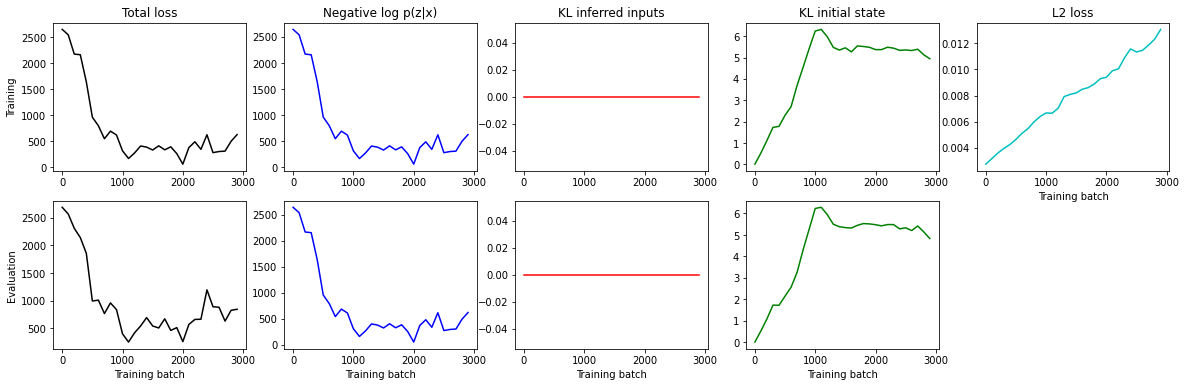

In [12]:
# Plot the training details
x = np.arange(0, num_batches, print_every)
plt.figure(figsize=(20,6))
plt.subplot(251)
plt.plot(x, opt_details['tlosses']['total'], 'k')
plt.ylabel('Training')
plt.title('Total loss')
plt.subplot(252)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.title('Negative log p(z|x)')
plt.subplot(253)
plt.plot(x, opt_details['tlosses']['kl_ii'], 'r')
plt.title('KL inferred inputs')
plt.subplot(254)
plt.plot(x, opt_details['tlosses']['kl_g0'], 'g')
plt.title('KL initial state')
plt.subplot(255)
plt.plot(x, opt_details['tlosses']['l2'], 'c')
plt.xlabel('Training batch')
plt.title('L2 loss')
plt.subplot(256)
plt.plot(x, opt_details['elosses']['total'], 'k')
plt.xlabel('Training batch')
plt.ylabel('Evaluation')
plt.subplot(257)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.xlabel('Training batch')
plt.subplot(258)
plt.plot(x, opt_details['elosses']['kl_ii'], 'r')
plt.xlabel('Training batch')
plt.subplot(259)
plt.plot(x, opt_details['elosses']['kl_g0'], 'g')
plt.xlabel('Training batch');

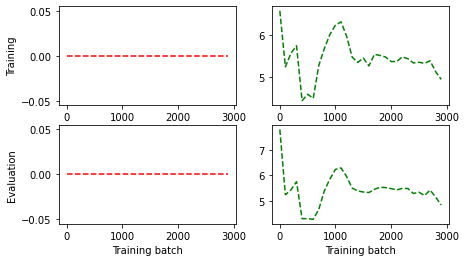

In [13]:
# See the effect of the KL warmup, which is shown 
# by the KL penalities without the warmup scaling. 
plt.figure(figsize=(7,4))
plt.subplot(221)
plt.plot(x, opt_details['tlosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Training')
plt.subplot(222)
plt.plot(x, opt_details['tlosses']['kl_g0_prescale'], 'g--')
plt.subplot(223)
plt.plot(x, opt_details['elosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Evaluation')
plt.xlabel('Training batch')
plt.subplot(224)
plt.plot(x, opt_details['elosses']['kl_g0_prescale'], 'g--')
plt.xlabel('Training batch');

### Visualize latent space trajectories

In [14]:
# Plot a bunch of examples of eval trials run through LFADS.

def plot_rescale_fun(a): 
    fac = max_firing_rate * data_dt
    return renormed_fun(a) * fac


bidx = 0

nexamples_to_save = 1
for eidx in range(nexamples_to_save):
    fkey = random.fold_in(key, eidx)
    psa_example = eval_data[bidx,:,:].astype(jnp.float32)
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example, gen=model)


dict_keys(['c_t', 'factor_t', 'gen_t', 'ic_logvar', 'ic_mean', 'ii_logvar_t', 'ii_mean_t', 'ii_t', 'lograte_t', 'xenc_t'])

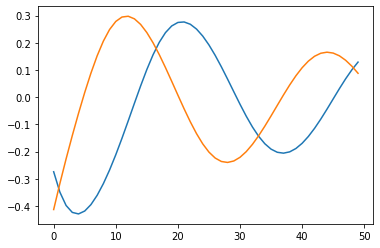

In [15]:
# plt.plot(psa_dict['factor_t'])
plt.plot(psa_dict['factor_t'])
psa_dict.keys()

In [16]:
# sample trajectories
ics = np.empty((data_bxtxn.shape[0],gen_dim))
gen_traj = np.empty((data_bxtxn.shape[0],ntimesteps,gen_dim))
for i, psa_example in enumerate(data_bxtxn.astype(jnp.float32)):
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example, gen=model)
    ics[i] = psa_dict['ic_mean']
    gen_traj[i] = psa_dict['gen_t']

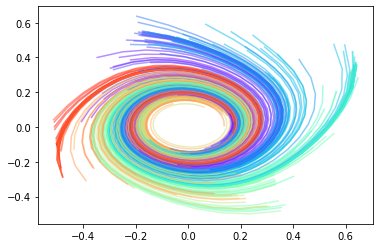

In [17]:
ncomponents = 2
pca = PCA(ncomponents)
pca.fit(np.reshape(gen_traj, [-1, gen_dim]))

S = pca.components_.T

for a,t in zip(reach_angle,gen_traj):
  plt.plot(*(t@S)[:,:].T, c=plt.cm.rainbow(a / (2*np.pi) + 0.5),alpha=0.5)



### Fixed point analysis

In [18]:
%load_ext autoreload
%autoreload 2
import fixed_point_finder.fixed_points as fp_optimize
from jax import vmap
import gc

gc.collect() # free up some RAM

19894

In [19]:
# These are some preliminaries. 
x_star = np.zeros(ii_dim)  # We always linearize the input around zero in this example.

# Make a one parameter function of thie hidden state, useful for jacobians.
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
params = hashabledict(model_params(key, gen_dim, ii_dim))
rnn_fun = lambda h : model(params, h, x_star)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))


Create some functions that define the fixed point loss
which is just the squared error of a point  for a discrete time system such as a VRNN or GRU.

In [20]:
fp_loss_fun = fp_optimize.get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = fp_optimize.get_total_fp_loss_fun(rnn_fun)

We have to start the fixed point finder with some points, and it's always best to start with examples of where the state normally operates.


In [21]:
fp_candidates = jnp.array(gen_traj[::50,])                        # was batch x time x dim
fp_candidates = jnp.reshape(fp_candidates, (-1, gen_dim))  # now (batch * time) x dim

In [22]:
# Fixed point optimization hyperparameters
fp_num_batches = 1000         # Total number of batches to train on.
fp_batch_size = 100          # How many examples in each batch
fp_step_size = 0.2          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 200   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.00001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.00001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025      # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.


In [23]:
fp_candidates.shape

(200, 2)

TODO rewrite

>When optimizing for fixed points, we set a few different stopping thresholds and run the fixed point finder a few times. This is because there are rarely true numerical fixed points, though they do happen. Instead one has slow points of varying slowness. My experience is that if the dynamics of the slow point is very slow relative to the normal speed of the dynamics during the task / computation / behavior, then the slow point is effectively acting as a fixed point. Moving forward, in the code, and in the comments, I always refer to slow points as fixed points, with the understanding that we are being informal. By having a few tolerances of varying slowness, we ensure we capture a large variety of the fixed points and likely get a better understanding of what the system is doing.

In [24]:
reload(fp_optimize)

fp_hps = {'num_batches' : fp_num_batches, 'step_size' : fp_step_size, 
            'decay_factor' : fp_decay_factor, 'decay_steps' : fp_decay_steps, 
            'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2,
            'adam_eps' : fp_adam_eps, 'noise_var' : fp_noise_var, 
            'fp_opt_stop_tol' : fp_opt_stop_tol, 'fp_tol' : fp_tol, 
            'unique_tol' : fp_unique_tol, 'outlier_tol' : fp_outlier_tol, 
            'opt_print_every' : fp_opt_print_every}

fp_hps = hashabledict(fp_hps)

fps, fp_losses, fp_idxs, fp_opt_details = \
  fp_optimize.find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)
if len(fp_idxs) > 0:
    F_of_fps = batch_rnn_fun(fps)
else:
    F_of_fps = np.zeros([0,gen_dim])
    
fps = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                'opt_details' : fp_opt_details, 'hps' : fp_hps}

fps


Optimizing to find fixed points.
    Batches 1-200 in 0.38 sec, Step size: 0.19604, Training loss 0.00000
Stopping as mean training loss 0.00000 is below tolerance 0.00001.
Excluding fixed points with squared speed above tolerance 0.00001.
    Kept 200/200 fixed points with tolerance under 0.000010.
Excluding non-unique fixed points.
    Kept 1/200 unique fixed points with uniqueness tolerance 0.025000.
Excluding outliers.
Sorting fixed points slowest first.


{'F_of_fps': DeviceArray([[-1.0462365e-05,  1.0912605e-05]], dtype=float32),
 'candidates': DeviceArray([[0.5406286, 0.4945531]], dtype=float32),
 'fps': DeviceArray([[1.4332895e-05, 8.8701236e-06]], dtype=float32),
 'hps': {'adam_b1': 0.9,
  'adam_b2': 0.999,
  'adam_eps': 1e-05,
  'decay_factor': 0.9999,
  'decay_steps': 1,
  'fp_opt_stop_tol': 1e-05,
  'fp_tol': 1e-05,
  'noise_var': 0.0,
  'num_batches': 1000,
  'opt_print_every': 200,
  'outlier_tol': 1.0,
  'step_size': 0.2,
  'unique_tol': 0.025},
 'losses': array([3.094883e-10], dtype=float32),
 'opt_details': {'fp_losses': [DeviceArray(3.9151477e-11, dtype=float32)]}}

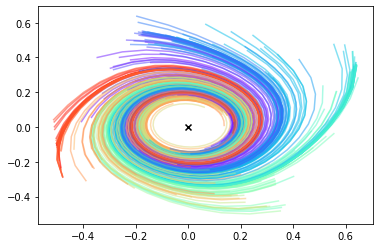

In [25]:
ncomponents = 2
pca = PCA(ncomponents)
pca.fit(np.reshape(gen_traj, [-1, gen_dim]))

S = pca.components_.T

for a,t in zip(reach_angle,gen_traj):
  plt.plot(*(t@S)[:,:].T, c=plt.cm.rainbow(a / (2*np.pi) + 0.5),alpha=0.5)


plt.scatter(*fps['fps'].T,c='k',marker='x')
# all_fps[0.0001]['fps'].shape

### Exercise 3: Linearizing around the fixed point: calculating the Jacobian

Given a matrix $A$ from a trained model

In [26]:
A = trained_params['gen']['wA']
np.linalg.eig(A)

(array([0.97848916+0.19562645j, 0.97848916-0.19562645j], dtype=complex64),
 array([[7.3200047e-01+0.j       , 7.3200047e-01-0.j       ],
        [1.3306124e-04+0.6813041j, 1.3306124e-04-0.6813041j]],
       dtype=complex64))

What is the frequency of oscillations?

In [27]:
end = time.time()

(end-start)/60

3.0710817495981853

# Parts 4: Modelling dynamics based on data

[Go to the next notebook](https://colab.research.google.com/drive/1CM6GLsDdUpaXcAnjjiLQGtUJZe5GH7MM?usp=sharing) WORK IN PROGRESS! 

# References
<a name="references"></a>
0. [Computation through dynamics tutorial](https://github.com/google-research/computation-thru-dynamics) from David Sussillo, which contains an implementation of LFADS that was adapted to this tutorial + extra material (in depth LFADS tutorial, inferring unobserved inputs, FORCE training)

1. *Manifold hypothesis:* Gallego, Juan A., et al. "Neural manifolds for the control of movement." Neuron 94.5 (2017): 978-984.

2. *A review of a population dynamics models:* Vyas, Saurabh, et al. "Computation through neural population dynamics." Annual Review of Neuroscience 43 (2020): 249. [Not paywalled pdf.](https://web.stanford.edu/~mgolub/publications/2020-Vyas-ARN.pdf)

3. *Our review on fully observed vs latent dynamical models*: Hurwitz, Cole, et al. [Building population models for large-scale neural recordings: Opportunities and pitfalls.](https://arxiv.org/pdf/2102.01807.pdf) Current Opinion in Neurobiology 70 (2021): 64-73.

4. *For better understanding of PCA:* [Dimensionality reduction tutorial](https://compneuro.neuromatch.io/tutorials/W1D4_DimensionalityReduction/chapter_title.html) by Alex Cayco Gajic at Neuromatch Academy

5. *The LFADS paper:* Pandarinath, Chethan, et al. [Inferring single-trial neural population dynamics using sequential auto-encoders.](https://www.nature.com/articles/s41592-018-0109-9) Nature methods 15.10 (2018): 805-815.

6. *Critical view on rotational dynamics* Lebedev, Mikhail A., et al. "Analysis of neuronal ensemble activity reveals the pitfalls and shortcomings of rotation dynamics." Scientific Reports 9.1 (2019): 1-14.
  
## Interesting recent papers for further reading

If you want to know what's going on in the field right now, you can check the following papers (a very biased selection from Nina ;) ):

1. Smith, Jimmy, Scott Linderman, and David Sussillo. [Reverse engineering recurrent neural networks with jacobian switching linear dynamical systems.](https://arxiv.org/pdf/2111.01256.pdf) Advances in Neural Information Processing Systems 34 (2021): 16700-16713.
2. 